# DGCNN

## Imports

In [ ]:
fn = 'pc'

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.2 MB/s 
     |████████████████████████████████| 407 kB 40.9 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import pandas as pd
import numpy as np
import json
import networkx as nx

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

## StellarGraph

Loading of the dataset. Each graph is converted to a **networkx** graph  and then to a **stellargraph**.

In [ ]:
DIR = ''

In [ ]:
with open(DIR+ 'stratified_samples/' + fn + '_stratified_sample.json', 'r') as file:
    graphs = [nx.node_link_graph(g) for g in json.load(file)]
    roots = [g.graph['root'] for g in graphs]
    nodes_list = [list(g.nodes.data('type')) for g in graphs]
    graph_labels = [n[1] for i in range(len(graphs)) for n in nodes_list[i] if n[0]== roots[i]] 

In [ ]:
# normalize nodes ids
for graph in graphs:
  mapping = {n: i for i,n in enumerate(graph.nodes)}
  nx.relabel_nodes(graph, mapping, copy=False)

# normalize node labels (type)
all_node_labels = sorted(set(t for g in graphs for _,t in g.nodes.data('type')))
mapping = pd.get_dummies(pd.Series(all_node_labels))
for graph in graphs:
  for n,t in graph.nodes.data('type'):
    graph.nodes[n]['feature'] = mapping[t]

In [ ]:
graph_labels = pd.Series(graph_labels)

In [ ]:
stellar_graphs = [StellarGraph.from_networkx(graphs[i], node_features="feature", edge_type_attr="key") for i in range(len(graphs))]

Saving dataset label for each graph

In [ ]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

### Prepare graph generator

To feed data to the `tf.Keras` model that we will create later, we need a data generator. For supervised graph classification, we create an instance of `StellarGraph`'s `PaddedGraphGenerator` class.

In [ ]:
generator = PaddedGraphGenerator(graphs=stellar_graphs)

### Create the Keras graph classification model

We are now ready to create a `tf.Keras` graph classification model using `StellarGraph`'s `DeepGraphCNN` class together with standard `tf.Keras` layers `Conv1D`, `MapPool1D`, `Dropout`, and `Dense`. 

The model's input is the graph represented by its adjacency and node features matrices. The first four layers are Graph Convolutional as in [2] but using the adjacency normalisation from [1], $D^{-1}A$ where $A$ is the adjacency matrix with self loops and $D$ is the corresponding degree matrix. The graph convolutional layers each have 32, 32, 32, 1 units and `tanh` activations. 

The next layer is a one dimensional convolutional layer, `Conv1D`, followed by a max pooling, `MaxPool1D`, layer. Next is a second `Conv1D` layer that is followed by two `Dense` layers the second used for binary classification. The convolutional and dense layers use `relu` activation except for the last dense layer that uses `sigmoid` for classification. As described in [1], we add a `Dropout` layer after the first `Dense` layer.

First we create the base DGCNN model that includes the graph convolutional and `SortPooling` layers.

In [ ]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 10]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Instructions for updating:
Use fn_output_signature instead


Next, we add the convolutional, max pooling, and dense layers.

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out) 
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

Finally, we create the `Keras` model and prepare it for training by specifying the loss and optimisation algorithm.

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Train the model

In [ ]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.7, test_size=None, stratify=graph_labels,
)

Given the data split into train and test sets, we create a `StellarGraph.PaddedGenerator` generator object that prepares the data for training. We create data generators suitable for training at `tf.keras` model by calling the latter generator's `flow` method specifying the train and test data.

In [ ]:
gen = PaddedGraphGenerator(graphs=stellar_graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

**Note**: We set the number of epochs to a large value so the call to `model.fit(...)` later might take a long time to complete. For faster performance set `epochs` to a smaller value; but if you do accuracy of the model found may be low.

In [ ]:
epochs = 100

We can now train the model by calling it's `fit` method.

In [ ]:
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
);

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


15/15 [==============================] - 4s 96ms/step - loss: 0.6873 - acc: 0.7440 - val_loss: 0.6776 - val_acc: 0.9307
Epoch 2/100
15/15 [==============================] - 1s 71ms/step - loss: 0.6665 - acc: 0.9323 - val_loss: 0.6506 - val_acc: 0.9335
Epoch 3/100
15/15 [==============================] - 1s 67ms/step - loss: 0.6310 - acc: 0.9335 - val_loss: 0.6049 - val_acc: 0.9335
Epoch 4/100
15/15 [==============================] - 1s 71ms/step - loss: 0.5756 - acc: 0.9335 - val_loss: 0.5355 - val_acc: 0.9335
Epoch 5/100
15/15 [==============================] - 1s 72ms/step - loss: 0.4930 - acc: 0.9335 - val_loss: 0.4463 - val_acc: 0.9335
Epoch 6/100
15/15 [==============================] - 1s 72ms/step - loss: 0.4048 - acc: 0.9335 - val_loss: 0.3565 - val_acc: 0.9335
Epoch 7/100
15/15 [==============================] - 1s 72ms/step - loss: 0.3261 - acc: 0.9335 - val_loss: 0.2923 - val_acc: 0.9335
Epoch 8/100
15/15 [==============================] - 1s 70ms/step - loss: 0.2800 - acc: 

Let us plot the training history (losses and accuracies for the train and test data).

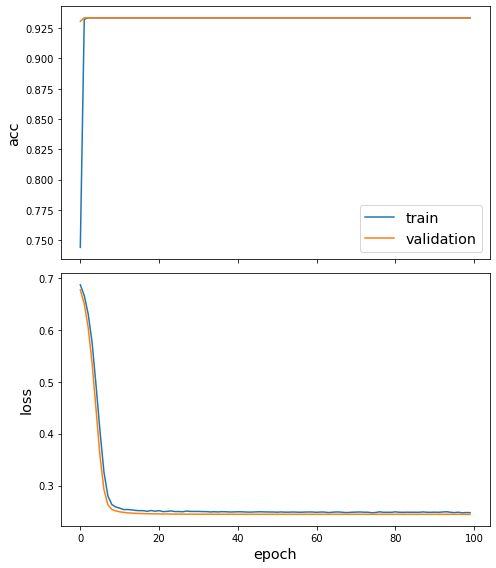

In [ ]:
sg.utils.plot_history(history)

Finally, let us calculate the performance of the trained model on the test data.

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

306/306 [==============================] - 1s 2ms/step - loss: 0.2444 - acc: 0.9335

Test Set Metrics:
	loss: 0.2444
	acc: 0.9335
